In [1]:
import os
import requests 
import pandas as pd
from dotenv import load_dotenv 
import numpy as np
import alpaca_trade_api as tradeapi 
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from pandas.tseries.offsets import DateOffset 
from sklearn.metrics import classification_report

# Import the hvPlot Library
import hvplot.pandas
import matplotlib.pyplot as plt

In [2]:
load_dotenv()

True

In [3]:
alpaca_api_key = os.getenv("ALPACA_API_KEY") 
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY") 

In [4]:
print(f'Alpaca Key Type:{type(alpaca_api_key)}')
print(f'Alpaca Secret Key Type: {type(alpaca_secret_key)}')

Alpaca Key Type:<class 'str'>
Alpaca Secret Key Type: <class 'str'>


In [5]:
alpaca_msft = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key, 
    api_version="v2")

In [6]:
start = pd.Timestamp('2018-09-01', tz='America/New_York').isoformat() 
end = pd.Timestamp('2023-08-31', tz='America/New_York').isoformat() 

In [7]:
tickers = ['MSFT']

In [8]:
timeframe = '1Day'

In [9]:
df_msft = alpaca_msft.get_bars(
    tickers,
    timeframe,
    start = start, 
    end = end
).df

In [10]:
df_msft.head() 
df_msft.tail()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2023-08-25 04:00:00+00:00,321.47,325.3600,318.8001,322.98,21562978,313463,322.105611,MSFT
2023-08-28 04:00:00+00:00,325.66,326.1500,321.7220,323.70,14811065,248331,323.413175,MSFT
2023-08-29 04:00:00+00:00,321.88,328.9835,321.8800,328.41,19297133,299500,327.169273,MSFT
2023-08-30 04:00:00+00:00,328.67,329.8100,326.4450,328.79,15228954,251354,328.547924,MSFT
2023-08-31 04:00:00+00:00,329.20,330.9099,326.7800,327.76,26418751,271739,328.087260,MSFT


In [11]:
# Filter the date index and close columns
msft_signals_df = df_msft.loc[:, ['close']]

msft_signals_df["Actual_Returns"] = msft_signals_df["close"].pct_change()

# Drop all the NaN values from the DataFrame
msft_signals_df = msft_signals_df.dropna()

# Review the DataFrame
display(msft_signals_df.head())
display(msft_signals_df.tail())

,close,Actual_Returns
timestamp,,
2018-09-05 04:00:00+00:00,108.49,-0.028825
2018-09-06 04:00:00+00:00,108.74,0.002304
2018-09-07 04:00:00+00:00,108.21,-0.004874
2018-09-10 04:00:00+00:00,109.38,0.010812
2018-09-11 04:00:00+00:00,111.24,0.017005


,close,Actual_Returns
timestamp,,
2023-08-25 04:00:00+00:00,322.98,0.009407
2023-08-28 04:00:00+00:00,323.70,0.002229
2023-08-29 04:00:00+00:00,328.41,0.014551
2023-08-30 04:00:00+00:00,328.79,0.001157
2023-08-31 04:00:00+00:00,327.76,-0.003133


In [12]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
msft_signals_df['SMA_Fast'] = msft_signals_df['close'].rolling(window=short_window).mean()
msft_signals_df['SMA_Slow'] = msft_signals_df['close'].rolling(window=long_window).mean()

msft_signals_df = msft_signals_df.dropna()

# Review the DataFrame
display(msft_signals_df.head())
display(msft_signals_df.tail())

,close,Actual_Returns,SMA_Fast,SMA_Slow
timestamp,,,,
2019-01-29 05:00:00+00:00,102.94,-0.020365,105.1050,107.4445
2019-01-30 05:00:00+00:00,106.38,0.033418,105.1500,107.4234
2019-01-31 05:00:00+00:00,104.43,-0.018331,104.7075,107.3803
2019-02-01 05:00:00+00:00,102.78,-0.015800,104.1325,107.3260
2019-02-04 05:00:00+00:00,105.74,0.028799,104.8325,107.2896


,close,Actual_Returns,SMA_Fast,SMA_Slow
timestamp,,,,
2023-08-25 04:00:00+00:00,322.98,0.009407,323.1025,321.3270
2023-08-28 04:00:00+00:00,323.70,0.002229,323.4125,321.6922
2023-08-29 04:00:00+00:00,328.41,0.014551,323.7650,322.1329
2023-08-30 04:00:00+00:00,328.79,0.001157,325.9700,322.5048
2023-08-31 04:00:00+00:00,327.76,-0.003133,327.1650,322.8885


In [13]:
# Initialize the new Signal column
msft_signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
msft_signals_df.loc[(msft_signals_df['Actual_Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
msft_signals_df.loc[(msft_signals_df['Actual_Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(msft_signals_df.head())
display(msft_signals_df.tail())

,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal
timestamp,,,,,
2019-01-29 05:00:00+00:00,102.94,-0.020365,105.1050,107.4445,-1.0
2019-01-30 05:00:00+00:00,106.38,0.033418,105.1500,107.4234,1.0
2019-01-31 05:00:00+00:00,104.43,-0.018331,104.7075,107.3803,-1.0
2019-02-01 05:00:00+00:00,102.78,-0.015800,104.1325,107.3260,-1.0
2019-02-04 05:00:00+00:00,105.74,0.028799,104.8325,107.2896,1.0


,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal
timestamp,,,,,
2023-08-25 04:00:00+00:00,322.98,0.009407,323.1025,321.3270,1.0
2023-08-28 04:00:00+00:00,323.70,0.002229,323.4125,321.6922,1.0
2023-08-29 04:00:00+00:00,328.41,0.014551,323.7650,322.1329,1.0
2023-08-30 04:00:00+00:00,328.79,0.001157,325.9700,322.5048,1.0
2023-08-31 04:00:00+00:00,327.76,-0.003133,327.1650,322.8885,-1.0


In [14]:
msft_signals_df['Signal'] = 0.0

msft_signals_df.loc[(msft_signals_df['Actual_Returns'] >= 0), 'Signal'] = 1

msft_signals_df.loc[(msft_signals_df['Actual_Returns'] < 0), 'Signal'] = -1

display(msft_signals_df.head())
display(msft_signals_df.tail())


,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal
timestamp,,,,,
2019-01-29 05:00:00+00:00,102.94,-0.020365,105.1050,107.4445,-1.0
2019-01-30 05:00:00+00:00,106.38,0.033418,105.1500,107.4234,1.0
2019-01-31 05:00:00+00:00,104.43,-0.018331,104.7075,107.3803,-1.0
2019-02-01 05:00:00+00:00,102.78,-0.015800,104.1325,107.3260,-1.0
2019-02-04 05:00:00+00:00,105.74,0.028799,104.8325,107.2896,1.0


,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal
timestamp,,,,,
2023-08-25 04:00:00+00:00,322.98,0.009407,323.1025,321.3270,1.0
2023-08-28 04:00:00+00:00,323.70,0.002229,323.4125,321.6922,1.0
2023-08-29 04:00:00+00:00,328.41,0.014551,323.7650,322.1329,1.0
2023-08-30 04:00:00+00:00,328.79,0.001157,325.9700,322.5048,1.0
2023-08-31 04:00:00+00:00,327.76,-0.003133,327.1650,322.8885,-1.0


In [15]:
# Identify the instances
msft_signals_df['Signal'].value_counts()

 1.0    617
-1.0    540
Name: Signal, dtype: int64

In [16]:
# Calculate the strategy returns and add them to the signals_df DataFrame
msft_signals_df['Strategy_Returns'] = msft_signals_df['Actual_Returns'] * msft_signals_df['Signal'].shift()

# Review the DataFrame
display(msft_signals_df.head())
display(msft_signals_df.tail())

,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal,Strategy_Returns
timestamp,,,,,,
2019-01-29 05:00:00+00:00,102.94,-0.020365,105.1050,107.4445,-1.0,NaN
2019-01-30 05:00:00+00:00,106.38,0.033418,105.1500,107.4234,1.0,-0.033418
2019-01-31 05:00:00+00:00,104.43,-0.018331,104.7075,107.3803,-1.0,-0.018331
2019-02-01 05:00:00+00:00,102.78,-0.015800,104.1325,107.3260,-1.0,0.015800
2019-02-04 05:00:00+00:00,105.74,0.028799,104.8325,107.2896,1.0,-0.028799


,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal,Strategy_Returns
timestamp,,,,,,
2023-08-25 04:00:00+00:00,322.98,0.009407,323.1025,321.3270,1.0,-0.009407
2023-08-28 04:00:00+00:00,323.70,0.002229,323.4125,321.6922,1.0,0.002229
2023-08-29 04:00:00+00:00,328.41,0.014551,323.7650,322.1329,1.0,0.014551
2023-08-30 04:00:00+00:00,328.79,0.001157,325.9700,322.5048,1.0,0.001157
2023-08-31 04:00:00+00:00,327.76,-0.003133,327.1650,322.8885,-1.0,-0.003133


In [17]:
msft_signals_df['Cumulative_Returns'] = (1 + msft_signals_df['Actual_Returns']).cumprod() - 1

msft_signals_df.head(20) 

,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal,Strategy_Returns,Cumulative_Returns
timestamp,,,,,,,
2019-01-29 05:00:00+00:00,102.94,-0.020365,105.1050,107.4445,-1.0,NaN,-0.020365
2019-01-30 05:00:00+00:00,106.38,0.033418,105.1500,107.4234,1.0,-0.033418,0.012372
2019-01-31 05:00:00+00:00,104.43,-0.018331,104.7075,107.3803,-1.0,-0.018331,-0.006186
2019-02-01 05:00:00+00:00,102.78,-0.015800,104.1325,107.3260,-1.0,0.015800,-0.021888
2019-02-04 05:00:00+00:00,105.74,0.028799,104.8325,107.2896,1.0,-0.028799,0.006281
2019-02-05 05:00:00+00:00,107.22,0.013997,105.0425,107.2494,1.0,0.013997,0.020365
2019-02-06 05:00:00+00:00,106.03,-0.011099,105.4425,107.1926,-1.0,-0.011099,0.009041
2019-02-07 05:00:00+00:00,105.27,-0.007168,106.0650,107.1162,-1.0,0.007168,0.001808
2019-02-08 05:00:00+00:00,105.67,0.003800,106.0475,107.0392,1.0,-0.003800,0.005615


<Axes: xlabel='timestamp'>

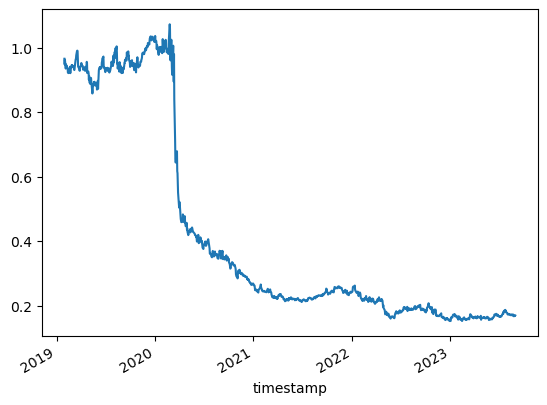

In [18]:
# Plot Strategy Returns to examine performance
(1 + msft_signals_df['Strategy_Returns']).cumprod().plot()

In [19]:
# Split the data into training and testing datasets
# Assign a copy of the sma_fast and sma_slow columns to features DataDrame called x
X = msft_signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna().copy()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
timestamp,,
2019-01-30 05:00:00+00:00,105.1050,107.4445
2019-01-31 05:00:00+00:00,105.1500,107.4234
2019-02-01 05:00:00+00:00,104.7075,107.3803
2019-02-04 05:00:00+00:00,104.1325,107.3260
2019-02-05 05:00:00+00:00,104.8325,107.2896


In [20]:
# Create the target set selecting the Signal column and assigning it a y
y = msft_signals_df['Signal'].copy()

# Review the value counts
y.value_counts()

 1.0    617
-1.0    540
Name: Signal, dtype: int64

In [21]:
# Select the start of the training period
training_begin = X.index.min() 

# Display the training begin date
print(training_begin)

2019-01-30 05:00:00+00:00


In [22]:
# Select the ending period for training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2019-04-30 05:00:00+00:00


In [23]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.tail()

,SMA_Fast,SMA_Slow
timestamp,,
2019-04-24 04:00:00+00:00,123.5850,110.1140
2019-04-25 04:00:00+00:00,124.3950,110.2927
2019-04-26 04:00:00+00:00,125.8400,110.4730
2019-04-29 04:00:00+00:00,127.3725,110.6700
2019-04-30 04:00:00+00:00,128.4550,110.8588


In [24]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Review the X_test DataFrame
X_test.tail()

,SMA_Fast,SMA_Slow
timestamp,,
2023-08-25 04:00:00+00:00,322.8275,320.9695
2023-08-28 04:00:00+00:00,323.1025,321.3270
2023-08-29 04:00:00+00:00,323.4125,321.6922
2023-08-30 04:00:00+00:00,323.7650,322.1329
2023-08-31 04:00:00+00:00,325.9700,322.5048


In [25]:
# Scale the features DataFrames
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X_train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [26]:
# Using the SVC Classifier Model from SKLeans Support Vector Machine (SVM) Learning Method to fit the training data and make predictions based on the testing data. 
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred_training = svm_model.predict(X_train_scaled)
svm_pred_testing = svm_model.predict(X_test_scaled)

# Review the model's predicted values
# YOUR CODE HERE
svm_pred_testing[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [27]:
# Review the classification Report associated with the SVC Models
# Use a classification report to evaluate the model using the predictions and testing data
svm_training_report = classification_report(y_train, svm_pred_training)

# Print the classification report

print(svm_training_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        21
         1.0       0.67      1.00      0.80        42

    accuracy                           0.67        63
   macro avg       0.33      0.50      0.40        63
weighted avg       0.44      0.67      0.53        63



/Users/staceysimko/anaconda3/envs/alpacaenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/staceysimko/anaconda3/envs/alpacaenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/staceysimko/anaconda3/envs/alpacaenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [28]:
#Backtesting SVM
svm_testing_signal_predictions = svm_model.predict(X_test_scaled) 
#Evaluate the Models's ability to predict the training signal for the testing data 
testing_report = classification_report(y_test, svm_testing_signal_predictions)
#Display the report
print(testing_report) 

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       518
         1.0       0.53      1.00      0.69       575

    accuracy                           0.53      1093
   macro avg       0.26      0.50      0.34      1093
weighted avg       0.28      0.53      0.36      1093



/Users/staceysimko/anaconda3/envs/alpacaenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/staceysimko/anaconda3/envs/alpacaenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/staceysimko/anaconda3/envs/alpacaenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [29]:
# Create a predictions DataFrame that contains columns for "Predicted" and "Actual Returns" and Strategy Returns"
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted_Signal'] = svm_testing_signal_predictions

# Add the actual returns to the DataFrame
predictions_df['Actual_Returns'] = msft_signals_df['Actual_Returns']

# Add the strategy returns to the DataFrame
predictions_df['SVM_Trading_Algorithm_Returns'] = predictions_df['Actual_Returns'] * predictions_df['Predicted_Signal']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted_Signal,Actual_Returns,SVM_Trading_Algorithm_Returns
timestamp,,,
2019-05-01 04:00:00+00:00,1.0,-0.020827,-0.020827
2019-05-02 04:00:00+00:00,1.0,-0.013059,-0.013059
2019-05-03 04:00:00+00:00,1.0,0.021314,0.021314
2019-05-06 04:00:00+00:00,1.0,-0.005818,-0.005818
2019-05-07 04:00:00+00:00,1.0,-0.020523,-0.020523


,Predicted_Signal,Actual_Returns,SVM_Trading_Algorithm_Returns
timestamp,,,
2023-08-25 04:00:00+00:00,1.0,0.009407,0.009407
2023-08-28 04:00:00+00:00,1.0,0.002229,0.002229
2023-08-29 04:00:00+00:00,1.0,0.014551,0.014551
2023-08-30 04:00:00+00:00,1.0,0.001157,0.001157
2023-08-31 04:00:00+00:00,1.0,-0.003133,-0.003133


# Create a cumulative return plot that displays actual vs. strategy; this will serve as the baseline to compare the effects of tunning the algorithm
cum_return_plot = (1 + predictions_df[['Actual_Returns', 'SVM_Trading_Algorithm_Returns']]).cumprod().plot()
 
# Save figure
cum_return_plot.get_figure().savefig("MSFT_Cumulative_Returns_Comparison.png")

In [30]:
# Tune the Baseline and Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression 

# Initiate the model instance
logistic_regression_model = LogisticRegression()

In [31]:
# Using the original training data as the baseline, fit the model with Logistics Regression
logistic_regression_model.fit(X_train_scaled, y_train)  

# Use the testing dataset to generate the predictions for the new model
lr_pred_train_signals = logistic_regression_model.predict(X_train_scaled)

# Review the model's predicted values
lr_pred_train_signals

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [32]:
# Generate a classification report using the training data and the logistics regression model's predictions
lr_training_report = classification_report(y_train, lr_pred_train_signals)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        21
         1.0       0.67      1.00      0.80        42

    accuracy                           0.67        63
   macro avg       0.33      0.50      0.40        63
weighted avg       0.44      0.67      0.53        63



/Users/staceysimko/anaconda3/envs/alpacaenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/staceysimko/anaconda3/envs/alpacaenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/staceysimko/anaconda3/envs/alpacaenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [33]:
# Backtest the new model to evaluate performance 
# Use a classification report to evaluate the model using the predictions and testing data
lr_testing_signal_predict = logistic_regression_model.predict(X_test_scaled)

# Generate the classification report 
lr_testing_report = classification_report(y_test, lr_testing_signal_predict)

# Print the classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       518
         1.0       0.53      1.00      0.69       575

    accuracy                           0.53      1093
   macro avg       0.26      0.50      0.34      1093
weighted avg       0.28      0.53      0.36      1093



/Users/staceysimko/anaconda3/envs/alpacaenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/staceysimko/anaconda3/envs/alpacaenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/staceysimko/anaconda3/envs/alpacaenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [34]:
# Create a new empty predictions DataFrame:
lr_predict_df = pd.DataFrame(index=X_test.index)

# Add the Logistic Regression model predictions to the DataFrame
lr_predict_df['Predicted'] = lr_testing_signal_predict

# Add the actual returns to the DataFrame
lr_predict_df['Actual_Returns'] = msft_signals_df['Actual_Returns']

# Add the strategy returns to the DataFrame
lr_predict_df['Logistics_Regression_Algo_Trading_Returns'] = lr_predict_df['Actual_Returns'] * lr_predict_df['Predicted']

# Review the DataFrame
display(lr_predict_df.head())
display(lr_predict_df.tail())

,Predicted,Actual_Returns,Logistics_Regression_Algo_Trading_Returns
timestamp,,,
2019-05-01 04:00:00+00:00,1.0,-0.020827,-0.020827
2019-05-02 04:00:00+00:00,1.0,-0.013059,-0.013059
2019-05-03 04:00:00+00:00,1.0,0.021314,0.021314
2019-05-06 04:00:00+00:00,1.0,-0.005818,-0.005818
2019-05-07 04:00:00+00:00,1.0,-0.020523,-0.020523


,Predicted,Actual_Returns,Logistics_Regression_Algo_Trading_Returns
timestamp,,,
2023-08-25 04:00:00+00:00,1.0,0.009407,0.009407
2023-08-28 04:00:00+00:00,1.0,0.002229,0.002229
2023-08-29 04:00:00+00:00,1.0,0.014551,0.014551
2023-08-30 04:00:00+00:00,1.0,0.001157,0.001157
2023-08-31 04:00:00+00:00,1.0,-0.003133,-0.003133


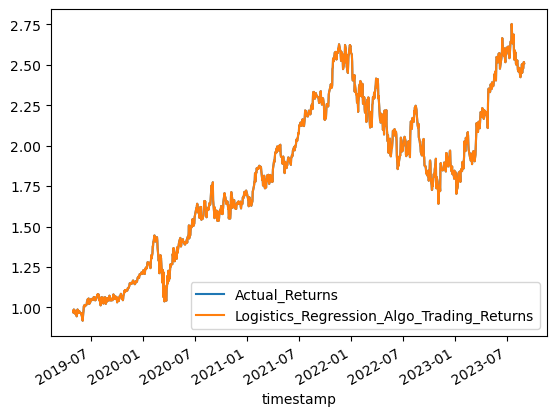

In [35]:
# Plot the actual returns versus the strategy returns
cum_return_plot_lr = (1 + lr_predict_df[['Actual_Returns', 'Logistics_Regression_Algo_Trading_Returns']]).cumprod().plot()
 
# Save figure
cum_return_plot_lr.get_figure().savefig("Cum_Ret_Logistic_Regression.png")

In [36]:
from sklearn.metrics import mean_absolute_error

actual_lr = lr_predict_df['Actual_Returns']
predicted_lr = lr_predict_df['Logistics_Regression_Algo_Trading_Returns']

mae_lr = mean_absolute_error(actual_lr , predicted_lr)
                             

print(f"Mean Absolute Error (MAE): {mae_lr}")

Mean Absolute Error (MAE): 0.0


In [37]:
# Create a list for the column names

columns = ["MSFT_Backtest_Performance_Metrics"]

# Create a list holding the names of the new evaluation metrics

metrics = [
    "Annualized_Returns",
    "Cumulative_Returns",
    "Annual_Volatility",
    "Sharpe_Ratio",
    "Sortino_Ratio",
    "Mean_Absolute_Error"]

# Initialize the DataFrame with index set to the evaluation metrics and the column
msft_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

# Review the sample DataFrame
msft_evaluation_df

,MSFT_Backtest_Performance_Metrics
Annualized_Returns,NaN
Cumulative_Returns,NaN
Annual_Volatility,NaN
Sharpe_Ratio,NaN
Sortino_Ratio,NaN
Mean_Absolute_Error,NaN


In [38]:
# Pass the MAE into the DataFrame
msft_evaluation_df.loc["Mean_Absolute_Error"] = mae_lr

In [39]:
# Calculate Metrics
msft_evaluation_df.loc["Annualized_Returns"] = (
    msft_signals_df['Actual_Returns'].mean() * 252
)

# Review the result
msft_evaluation_df


,MSFT_Backtest_Performance_Metrics
Annualized_Returns,0.296166
Cumulative_Returns,NaN
Annual_Volatility,NaN
Sharpe_Ratio,NaN
Sortino_Ratio,NaN
Mean_Absolute_Error,0.0


In [40]:
# Calculate the portfolio cumulative returns
msft_evaluation_df.loc["Cumulative_Returns"] =  msft_signals_df["Cumulative_Returns"][-1]

# Preview the DataFrame
msft_evaluation_df

,MSFT_Backtest_Performance_Metrics
Annualized_Returns,0.296166
Cumulative_Returns,2.119147
Annual_Volatility,NaN
Sharpe_Ratio,NaN
Sortino_Ratio,NaN
Mean_Absolute_Error,0.0


In [41]:
# Calculate the annual volatility
msft_evaluation_df.loc['Annual_Volatility'] = (
    msft_signals_df['Actual_Returns'].std() * np.sqrt(252)
)

# Preview the DataFrame
msft_evaluation_df

,MSFT_Backtest_Performance_Metrics
Annualized_Returns,0.296166
Cumulative_Returns,2.119147
Annual_Volatility,0.310792
Sharpe_Ratio,NaN
Sortino_Ratio,NaN
Mean_Absolute_Error,0.0


In [42]:
# Calculate Sharpe Ratio
msft_evaluation_df.loc['Sharpe_Ratio'] = (
    msft_signals_df['Actual_Returns'].mean() * 252) / (
   msft_signals_df['Actual_Returns'].std() * np.sqrt(252)
)

# Preview the DataFrame
msft_evaluation_df

,MSFT_Backtest_Performance_Metrics
Annualized_Returns,0.296166
Cumulative_Returns,2.119147
Annual_Volatility,0.310792
Sharpe_Ratio,0.95294
Sortino_Ratio,NaN
Mean_Absolute_Error,0.0


In [43]:
# Sortino Ratio Calculation 
sortino_ratio_df =  msft_signals_df[["Actual_Returns"]].copy()

# Create a column to hold downside return values
sortino_ratio_df.loc[:, "Downside_Returns"] = 0

# Find Portfolio Daily Returns values than 0,
# Square those values, and add them to the Downside_Returns column
sortino_ratio_df.loc[sortino_ratio_df["Actual_Returns"] < 0,
                     "Downside_Returns"] = sortino_ratio_df["Actual_Returns"]**2
                                                            
# Review the DataFrame
sortino_ratio_df.tail()

,Actual_Returns,Downside_Returns
timestamp,,
2023-08-25 04:00:00+00:00,0.009407,0.00000
2023-08-28 04:00:00+00:00,0.002229,0.00000
2023-08-29 04:00:00+00:00,0.014551,0.00000
2023-08-30 04:00:00+00:00,0.001157,0.00000
2023-08-31 04:00:00+00:00,-0.003133,0.00001


In [44]:
# Calculate the annual downside standard deviation value
downside_standard_deviation = (
    np.sqrt(sortino_ratio_df["Downside_Returns"].mean()) * np.sqrt(252)
)

print(f"Annual Downside Standard Deviation: {downside_standard_deviation}")

Annual Downside Standard Deviation: 0.21042044455200454


In [45]:
# The Sortino Ratio is reached by dividing the annualized return value by the downside standard deviation 
sortino_ratio = (msft_evaluation_df.loc["Annualized_Returns"] / downside_standard_deviation)

# Add the Sortino Ratio to the evaluation metric
msft_evaluation_df.loc['Sortino_Ratio'] = sortino_ratio

# Review the entire DataFrame
msft_evaluation_df

,MSFT_Backtest_Performance_Metrics
Annualized_Returns,0.296166
Cumulative_Returns,2.119147
Annual_Volatility,0.310792
Sharpe_Ratio,0.95294
Sortino_Ratio,1.407498
Mean_Absolute_Error,0.0


In [46]:
# Reorganized the df_msft DataFrame for the MCSimulation 
msft_ticker_data_df = pd.concat([df_msft], axis=1, keys=['MSFT'])

# Display the sample data
msft_ticker_data_df

MSFT                                        \
                             open      high       low   close    volume   
timestamp                                                                 
2018-09-04 04:00:00+00:00  110.85  111.9550  110.2200  111.71  22634845   
2018-09-05 04:00:00+00:00  111.01  111.4200  108.1000  108.49  32872362   
2018-09-06 04:00:00+00:00  108.25  108.9900  107.5100  108.74  23477719   
2018-09-07 04:00:00+00:00  108.23  108.7248  107.2300  108.21  22498646   
2018-09-10 04:00:00+00:00  108.84  109.6400  108.3600  109.38  20728405   
...                           ...       ...       ...     ...       ...   
2023-08-25 04:00:00+00:00  321.47  325.3600  318.8001  322.98  21562978   
2023-08-28 04:00:00+00:00  325.66  326.1500  321.7220  323.70  14811065   
2023-08-29 04:00:00+00:00  321.88  328.9835  321.8800  328.41  19297133   
2023-08-30 04:00:00+00:00  328.67  329.8100  326.4450  328.79  15228954   
2023-08-31 04:00:00+00:00  329.20  330.9099  326.7800  327.76  26418751   

                                                          
                          trade_count        vwap symbol  
timestamp                                                 
2018-09-04 04:00:00+00:00      168424  111.402999   MSFT  
2018-09-05 04:00:00+00:00      234348  109.006583   MSFT  
2018-09-06 04:00:00+00:00      172965  108.396926   MSFT  
2018-09-07 04:00:00+00:00      162158  108.216530   MSFT  
2018-09-10 04:00:00+00:00      127933  109.176517   MSFT  
...                               ...         ...    ...  
2023-08-25 04:00:00+00:00      313463  322.105611   MSFT  
2023-08-28 04:00:00+00:00      248331  323.413175   MSFT  
2023-08-29 04:00:00+00:00      299500  327.169273   MSFT  
2023-08-30 04:00:00+00:00      251354  328.547924   MSFT  
2023-08-31 04:00:00+00:00      271739  328.087260   MSFT  

[1257 rows x 8 columns]

In [47]:
?MCSimulation

Object `MCSimulation` not found.


In [48]:
from MCForecastTools import MCSimulation 
MC_twoyear = MCSimulation (
    portfolio_data = msft_ticker_data_df,
    num_simulation = 500,
    num_trading_days = 252*2
)

In [49]:
MC_twoyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.


/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.


/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.


/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Monte Carlo simulation number 340.


/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

Running Monte Carlo simulation number 350.
Running Monte Carlo simulation number 360.
Running Monte Carlo simulation number 370.
Running Monte Carlo simulation number 380.
Running Monte Carlo simulation number 390.
Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 410.


/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

Running Monte Carlo simulation number 420.
Running Monte Carlo simulation number 430.
Running Monte Carlo simulation number 440.
Running Monte Carlo simulation number 450.
Running Monte Carlo simulation number 460.
Running Monte Carlo simulation number 470.
Running Monte Carlo simulation number 480.


/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

Running Monte Carlo simulation number 490.


/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003277,1.039561,1.009946,1.003039,0.965636,0.982936,1.000053,0.989886,1.006446,0.997162,...,1.013887,0.994629,0.972757,1.002435,1.006678,1.021631,1.024667,1.006453,0.969320,0.972210
2,0.998559,1.053674,0.989853,0.985345,0.958781,1.009065,1.010303,0.976695,1.016490,1.014648,...,1.015357,0.987509,0.985879,1.005263,1.017736,1.023555,1.035595,1.032261,0.970105,0.973916
3,0.976471,1.033180,0.997383,1.013991,0.935109,1.040349,1.010474,0.983876,1.021343,1.001460,...,1.018056,1.000584,1.005454,0.951386,1.024367,1.039554,1.045940,1.046177,0.991599,0.985511
4,0.985653,1.008376,0.997858,1.008677,0.922151,1.036393,1.015935,1.008209,1.028765,1.020649,...,0.996571,0.989531,0.990854,0.942916,1.064363,1.058589,1.041069,1.007819,0.989254,0.998097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,2.528233,1.520565,0.923839,1.627578,0.832312,2.477421,1.524433,1.364385,1.666830,1.810761,...,3.331844,2.390573,1.135935,0.946375,1.590482,1.381212,1.538392,3.334768,5.424928,3.113060
501,2.580218,1.536483,0.916839,1.611486,0.782285,2.456647,1.542149,1.316715,1.662378,1.809325,...,3.248035,2.429235,1.162170,0.961588,1.612698,1.344327,1.527688,3.321723,5.556520,3.052839
502,2.617585,1.521765,0.920548,1.618612,0.784967,2.464001,1.543664,1.337102,1.644823,1.815874,...,3.243200,2.499203,1.139774,0.982037,1.609472,1.333731,1.555373,3.434154,5.430939,3.164725
503,2.626056,1.514639,0.968923,1.547583,0.785979,2.432504,1.539572,1.352028,1.641937,1.848218,...,3.276028,2.582214,1.143333,0.968140,1.651176,1.320060,1.599890,3.274699,5.389201,3.145391


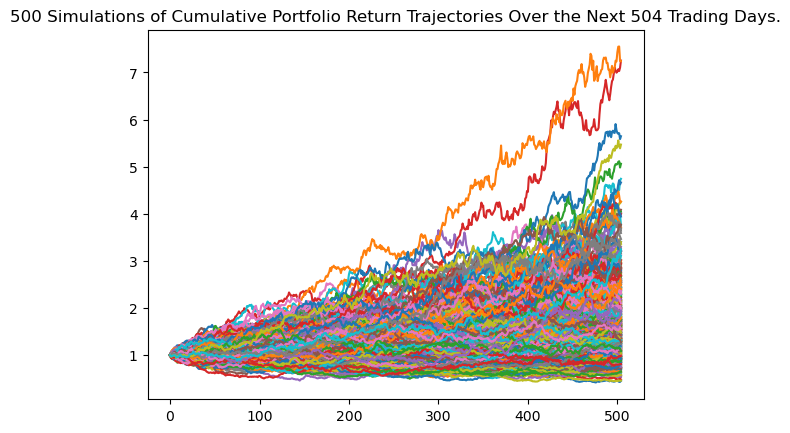

In [50]:
# Plot MCSimulation 
msft_line_plot = MC_twoyear.plot_simulation()

In [51]:
# Compute summary statistics from simulated daily returns
msft_simulated_returns_data = {
    "mean": list(MC_twoyear.simulated_return.mean(axis =1)),
    "median": list(MC_twoyear.simulated_return.median(axis =1)),
    "min": list(MC_twoyear.simulated_return.min(axis =1)),
    "max": list(MC_twoyear.simulated_return.max(axis =1))
}
# Create a DataFrame with the Summary Stats
df_msft_simulated_returns = pd.DataFrame(msft_simulated_returns_data)

# Display the sample data
df_msft_simulated_returns.head()

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,1.001780,1.002243,0.937894,1.065373
2,1.004005,1.002528,0.922983,1.093633
3,1.006048,1.005270,0.914177,1.115232
4,1.008176,1.005233,0.902794,1.142606


<Axes: title={'center': 'Microsoft Daily Returns Simulated Over the Next Two Years'}>

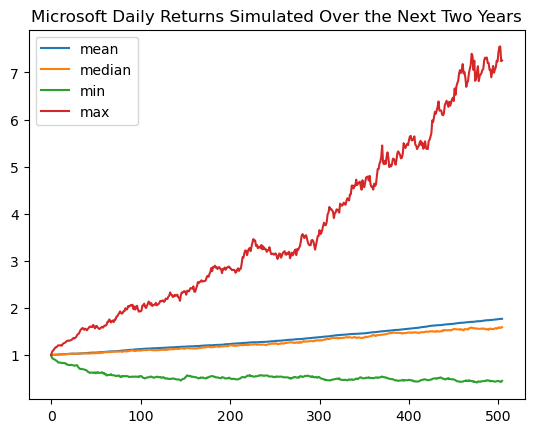

In [52]:
# Plot the simulated returns over the next 2 years
df_msft_simulated_returns.plot(title = "Microsoft Daily Returns Simulated Over the Next Two Years")

In [53]:
tbl = MC_twoyear.summarize_cumulative_return()

print(tbl)

count           500.000000
mean              1.769624
std               0.886536
min               0.453070
25%               1.176486
50%               1.591700
75%               2.147805
max               7.252071
95% CI Lower      0.644543
95% CI Upper      3.969376
Name: 504, dtype: float64


/Users/staceysimko/UNCC-VIRT-FIN-PT-U-LOLC/Project 2/MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)
